In [1]:
using DrWatson
@quickactivate

In [2]:
using main
using BlockDiagonals, LinearAlgebra, Plots, ProgressMeter
using Distributions, MCMCChains, Random

gr(fmt=:png, levels=5, lw=0.5, msa=0.1, msw=0.5, ma=0.2, msc=:firebrick1, legend=:topright)
ProgressMeter.ijulia_behavior(:clear);

[ Info: Precompiling main [d4387e3f-b08f-4148-9d80-1476cd5e70f5]
┌ Warning: backend `GR` is not installed.
└ @ Plots /storage/home/s/suv87/work/julia_depot/packages/Plots/nqFaB/src/backends.jl:37
[ Info: GR
[ Info: Precompiling BlockDiagonals [0a1fb500-61f7-11e9-3c65-f5ef3456f9f0]
[ Info: Precompiling MCMCChains [c7f686f2-ff18-58e9-bc7b-31028e88f75d]


In [3]:
function generate_model(; m = 5.0 ,s = 0.5, d = 10)
    R = prod(
    # [BlockDiagonal([diagm(ones(j)), [0.0 -1.0; 1.0 0.0], diagm(ones(d - j - 2))]) for j in 0:d-2]
        [
        BlockDiagonal(
            [diagm(ones(2j)),
            [0.0 -1.0; 1.0 0.0],
            diagm(ones(d - 2j - 2))]
        ) for j in 0:round(Int, d / 2 - 1)
    ]
    )

    Σ₁ = [s^abs(i - j) for i in 1:d, j in 1:d]
    Σ₂ = R * Σ₁ * R'
    μ = [-m .* ones(d), m .* ones(d)]
    Σ = [Σ₁, Σ₂]

    ξ = MixtureModel(
        [MvNormal(x, y) for (x, y) in zip(μ, Σ)],
        [0.5, 0.5]
    )
    return Model(ξ=ξ)
end

generate_model (generic function with 1 method)

In [87]:
function acfplots(chains, names, lags=0:2:20; kwargs...)
    plt = plot(0, 0)
    for (x, n) in zip(chains, names)
        plt = plot(plt, mean(1 .* (autocor(x, lags=[lags...])[:, :]), dims=1)', label=n; kwargs...)
    end
    return plt
end

function scatterplots(xs, names; baseplt=plot(0,0,label=nothing), l=400, kwargs...)
    L = length(xs)
    ds = sample(1:size(xs[1], 2), 2, replace=false)
    plts = [scatter(baseplt, x[:, ds[1]], x[:, ds[2]], label=names[i]) for (x, i) in zip(xs, eachindex(xs))]
    plot(plts..., axes=false, ticks=false; kwargs...)
end

function traceplots(xs, names, args...; baseplt=plot(0,0,label=nothing), l=400, kwargs...)
    L = length(xs)
    ds = sample(1:size(xs[1], 2), 1, replace=false)
    plts = [plot(x[:, ds[1]], label=names[i]; args...) for (x, i) in zip(xs, eachindex(xs))]
    plot(plts...; kwargs...)
end

function mean_ess(chains)
    return [ess_rhat(chn)[:, 2] |> mean for chn in chains]
end

function w2_minibatch(xs, model; eps=0.1, iters=100, k=100, N=64)
    results = zeros(length(xs))
    for (i, x) in zip(eachindex(xs), xs)
        z = Matrix(rand(model.ξ, size(x, 1))')
        results[i] = W2_minibatch(x, z, eps=eps, iters=iters, k=k, N=N)
    end
    return results
end

function scatterplot(plt, x; lw=0.1, la=0.2, col=:black, kwargs...)
    scatter(plt, x; kwargs...)
    plot!(x, lw=lw, la=la, c=col, label="")
end

scatterplot (generic function with 1 method)

# Example: $\mathbb R^{2}$

In [5]:
model = generate_model(d=2);

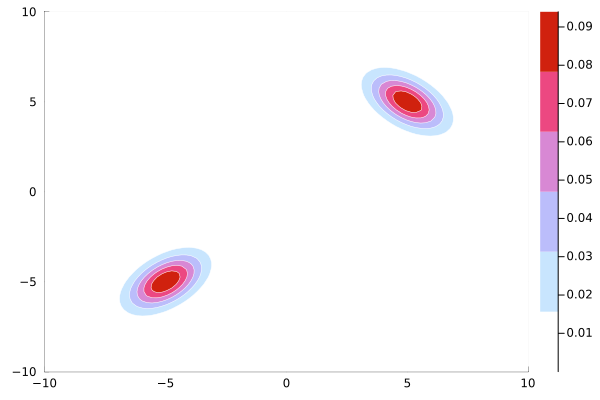

In [6]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)
plt(; lim=(-10, 10)) = contourf(
    repeat([range(lim..., length=100)], 2)..., 
    (x, y) -> model.f([x; y])^(1-1e-2), 
    c=cls
)
plt2 = plt()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  HMC(0.5325990075857109, 9, Any[]):  0.9672065586882623


Acceptance Ratio = 0.9678
  1.716573 seconds (4.77 M allocations: 271.106 MiB, 4.19% gc time)


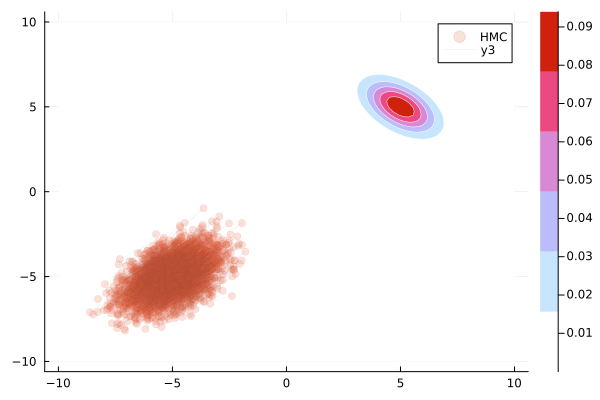

In [56]:
@time s1, a1 = mcmc(
    DualAverage(λ=5, δ=0.8),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_hmc = s1[a1, :]
chain_hmc = Chains(x_hmc)
plt2_hmc = scatterplot(plt(), x_hmc[:, 1:2] |> m2t, label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
  HaRAM(0.23545294400929165, 42, 0.2998971422900903, Any[]):  0.743251349730054


Acceptance Ratio = 0.7429
 12.749307 seconds (37.88 M allocations: 2.106 GiB, 6.34% gc time)


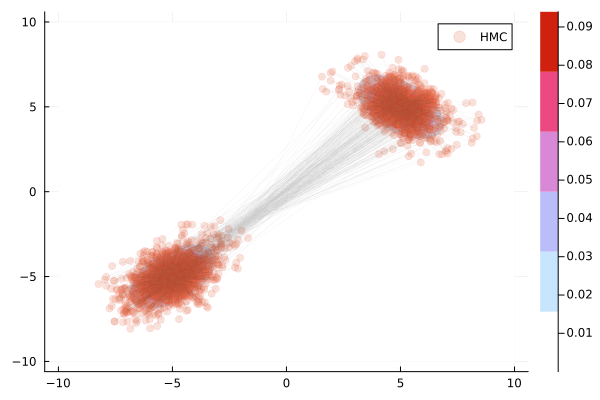

In [71]:
@time s2, a2 = mcmc(
    DualAverage(λ=10, δ=0.6),
    HaRAM(),
    model; n=5e3, n_burn=1e3
)
x_haram = s2[a2, :]
chain_haram = Chains(x_haram)
plt2_haram = scatterplot(plt(), x_haram[:, 1:2] |> m2t, label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(MvNormal{Int64, PDMats.ScalMat{Int64}, FillArrays.Zeros{Int64, 1, Tuple{Base.OneTo{Int64}}}}(
dim: 2
μ: Zeros(2)
Σ: [25 0; 0 25]
)
, [0.8496592789273161, 0.0446100025813457], Any[]):       0.16680553241126478


Acceptance Ratio = 0.1661
  0.225464 seconds (1.12 M allocations: 61.572 MiB, 20.93% gc time)


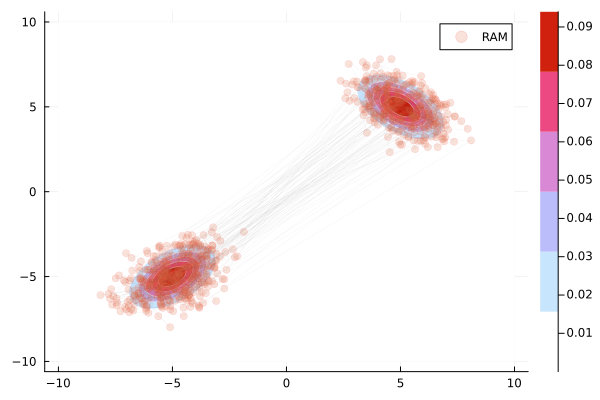

In [74]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 5), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_ram = s3[a3, :]
chain_ram = Chains(x_ram)
plt2_ram = scatterplot(plt(), x_ram[:, 1:2] |> m2t, label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
  PEHMC:  0.7965485921889192


Acceptance Ratio = 0.8004
 75.684920 seconds (133.76 M allocations: 6.167 GiB, 4.12% gc time, 56.50% compilation time)


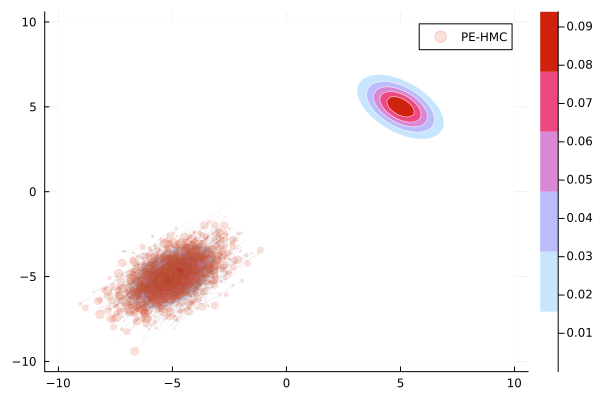

In [73]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.8, L=5, N=2),
    model; n=1e3, n_burn=1e2
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_pehmc = Chains(x_pehmc)
plt2_pehmc = scatterplot(plt(), x_pehmc |> m2t, ms=w_pehmc * 5, label="PE-HMC")

In [95]:
scatterplot(plt(), x_haram[:, 1:2] |> m2t, la=0.1, lw=1, label="RAM")
savefig("./plots/test.pdf")

"/storage/work/s/suv87/julia/haram/notebooks/new/plots/test.pdf"

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
  HMC:  0.9281883465139533


Acceptance Ratio = 0.9276
  4.553540 seconds (11.07 M allocations: 629.619 MiB, 5.78% gc time, 22.32% compilation time)


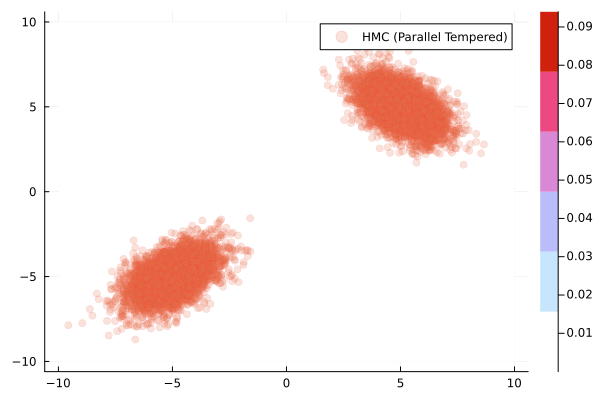

In [11]:
@time s5, a5 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HMC(ϵ=0.95, L=2),
    model; n=1e4, n_burn=1e3
)
x_pt_hmc = s5[a5, :]
chain_pt_hmc = Chains(x_pt_hmc)
plt2_pt_hmc = scatterplot(plt(), x_pt_hmc[:, 1:2] |> m2t, label="HMC (Parallel Tempered)")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
  HMC:  0.9617307517498409


Acceptance Ratio = 0.962
  4.176232 seconds (12.05 M allocations: 690.549 MiB, 6.30% gc time)


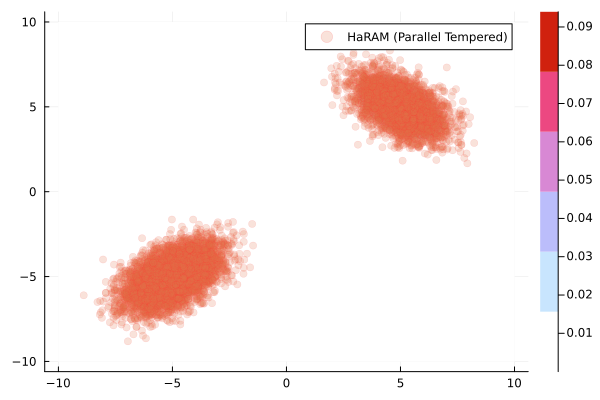

In [12]:
@time s6, a6 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HMC(ϵ=0.5, L=3),
    model; n=1e4, n_burn=1e3
)
x_pt_haram = s6[a6, :]
chain_pt_haram = Chains(x_pt_haram)
plt2_pt_haram = scatterplot(plt(), x_pt_haram[:, 1:2] |> m2t, label="HaRAM (Parallel Tempered)")

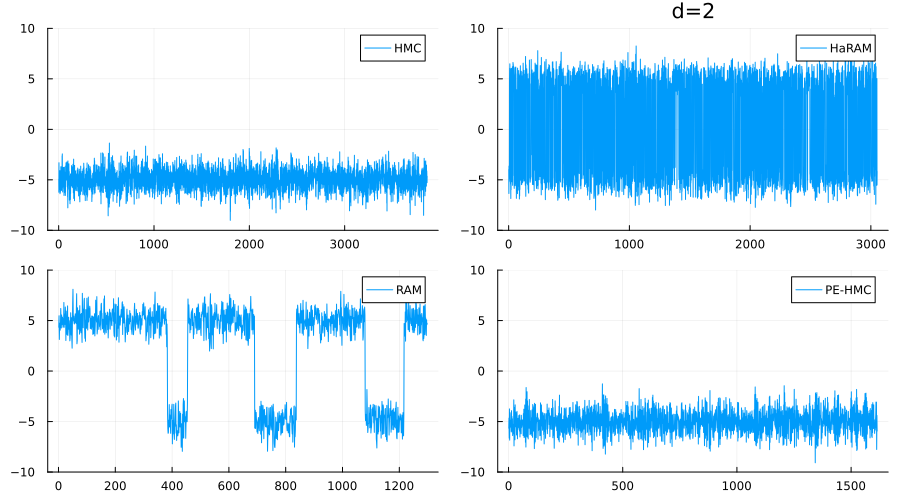

In [13]:
names = ("HMC", "HaRAM", "RAM", "PE-HMC")
xs2d = [x_hmc, x_haram, x_ram, x_pehmc]
chains2d = [chain_hmc, chain_haram, chain_ram, chain_pehmc];

plt2_tr = traceplots(xs2d, names, lw=1, layout=(2,2), ylim=(-10,10), l=100, size=(900, 500), title=["" "d=2" "" ""])

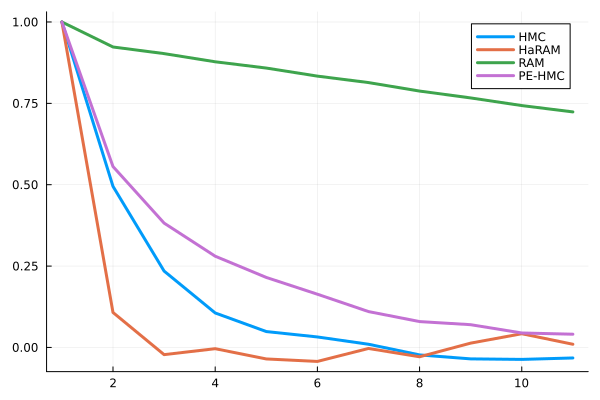

In [14]:
plt2_acf = acfplots(chains2d, names, lw=3)

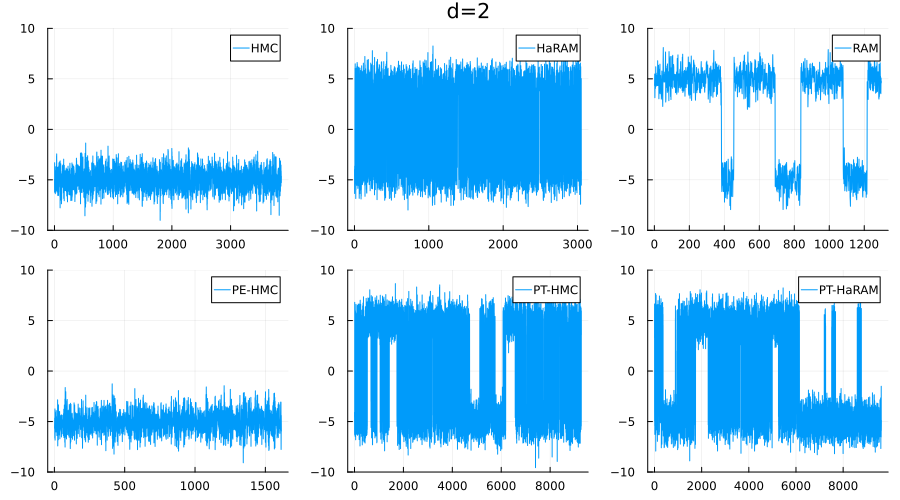

In [15]:
names = ("HMC", "HaRAM", "RAM", "PE-HMC", "PT-HMC", "PT-HaRAM")
xs2d = [x_hmc, x_haram, x_ram, x_pehmc, x_pt_hmc, x_pt_haram]
chains2d = [chain_hmc, chain_haram, chain_ram, chain_pehmc, chain_pt_hmc, chain_pt_haram];


plt2_acf_all = acfplots(chains2d, names, lw=3, title="d=2")
plt2_tr_all = traceplots(xs2d, names, lw=1, layout=(2,3), ylim=(-10,10), l=100, size=(900, 500), title=["" "d=2" "" "" "" "" ""])

# @pipe ["plt2_tr_all", "plt2_acf_all"] .|>
# begin 
#     plot(eval(Meta.parse(_))); savefig.(plotsdir.("gaussian3/d2/" .* _ .* [".pdf", ".svg"] )) 
# end;

In [16]:
# @pipe ["plt2_tr", "plt2_acf", "plt2_hmc", "plt2_haram", "plt2_ram", "plt2_pehmc", "plt2_pt_hmc", "plt2_pt_haram"] .|> 
# begin 
#     plot(eval(Meta.parse(_))); savefig.(plotsdir.("gaussian3/d2/" .* _ .* [".pdf", ".svg"] )) 
# end;

In [17]:
w2_minibatch(xs2d, model)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


6-element Vector{Float64}:
 0.28629279164425325
 0.010284294654792542
 0.02904278457553866
 0.5726606625322331
 0.003666322920113577
 0.003493028234731236

# Example: $\mathbb R^{10}$

In [18]:
model = generate_model(d=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
  HMC(0.6725894529380222, 22, Any[]):  0.7698075481129718


Acceptance Ratio = 0.7682
  8.365223 seconds (10.32 M allocations: 4.175 GiB, 6.67% gc time, 14.64% compilation time)


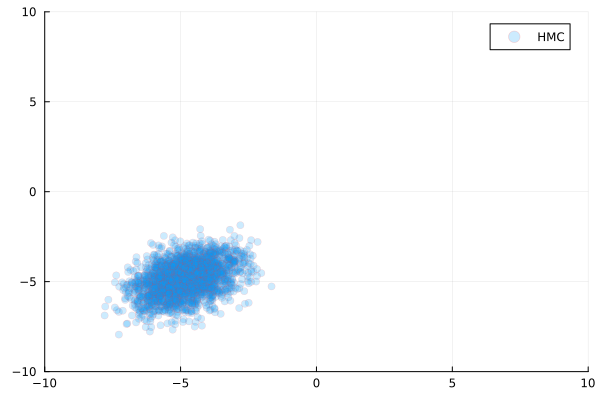

In [19]:
@time s1, a1 = mcmc(
    DualAverage(λ=15, δ=0.6),
    HMC(),
    model; n=4e3, n_burn=1e3
)
x_10_hmc = s1[a1, :]
chain_10_hmc = Chains(x_10_hmc)
plt10_hmc = scatterplot(x_10_hmc[:, 1:2] |> m2t, lim=(-10, 10), label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
  HaRAM(0.1942157790562792, 103, 0.27584707531680985, Any[]):  0.5271182204448888


Acceptance Ratio = 0.5249
 46.997795 seconds (61.41 M allocations: 29.976 GiB, 7.78% gc time)


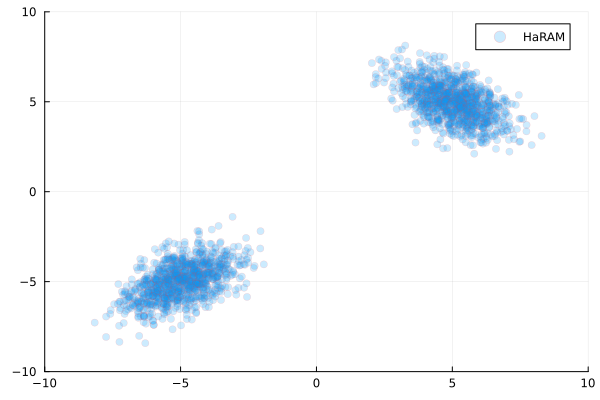

In [20]:
@time s2, a2 = mcmc(
    DualAverage(λ=20, δ=0.6),
    HaRAM(),
    model; n=4e3, n_burn=1e2
)
x_10_haram = s2[a2, :]
chain_10_haram = Chains(x_10_haram)
plt10_haram = scatterplot(x_10_haram[:, 1:2] |> m2t, lim=(-10, 10), label="HaRAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(ZeroMeanIsoNormal(
dim: 10
μ: Zeros(10)
Σ: [0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25]
)
, [0.6202731147826146, -1.2729841193568543, 0.6759610947266154, 1.2642077706298387, -0.264491540930165, -0.6035805379815434, -0.2527922558070094, 0.32325713794794925, 1.7010555369596483, 0.7062202797610374], Any[]):       0.3359328134373125


Acceptance Ratio = 0.3296
  0.642977 seconds (1.12 M allocations: 78.239 MiB, 64.22% compilation time)


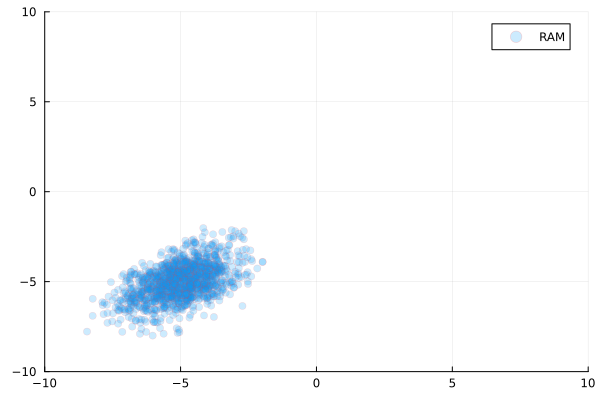

In [21]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 0.5), z=randn(model.d)),
    model; n=4e3, n_burn=1e3
)
x_10_ram = s3[a3, :]
chain_10_ram = Chains(x_10_ram)
plt10_ram = scatterplot(x_10_ram[:, 1:2] |> m2t, lim=(-10, 10), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:54
  PEHMC:  0.9227974568574023


Acceptance Ratio = 0.9281
114.019763 seconds (272.49 M allocations: 12.841 GiB, 3.52% gc time)


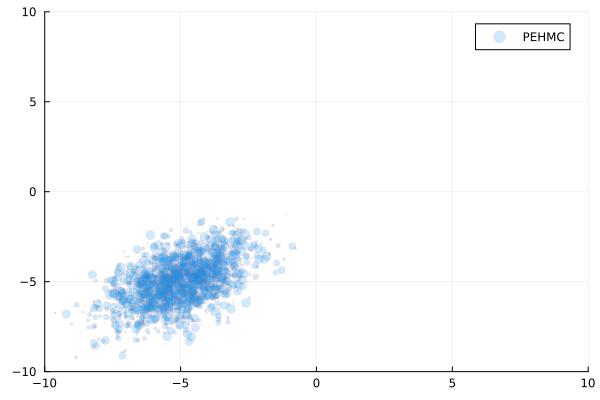

In [22]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.25, L=20, N=2),
    model; n=1e3, n_burn=1e2
)
x_10_pehmc, w_10_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_10_pehmc = Chains(x_10_pehmc)
plt10_pehmc = scatterplot(x_10_pehmc[:, 1:2] |> m2t, ms=w_10_pehmc * 5, lim=(-10, 10), label="PEHMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
  HMC:  0.7690461907618477


Acceptance Ratio = 0.7721
 17.717505 seconds (23.10 M allocations: 10.970 GiB, 8.10% gc time)


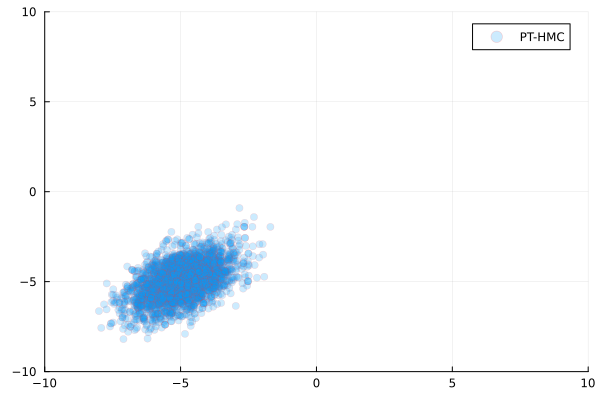

In [23]:
@time s5, a5 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HMC(ϵ=0.65, L=20),
    model; n=4e3, n_burn=1e3
)
x_10_pt_hmc = s5[a5, :]
chain_10_pt_hmc = Chains(x_10_pt_hmc)
plt10_pt_hmc = scatterplot(x_10_pt_hmc[:, 1:2] |> m2t, lim=(-10, 10), label="PT-HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
  HaRAM:  0.47890421915616876


Acceptance Ratio = 0.4803
 43.286403 seconds (56.80 M allocations: 27.285 GiB, 7.68% gc time, 0.64% compilation time)


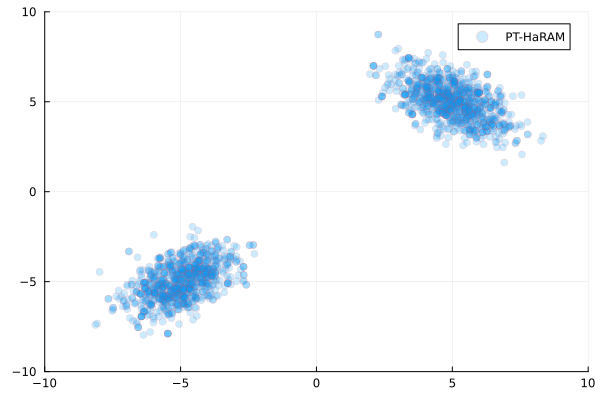

In [24]:
@time s6, a6 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HaRAM(ϵ=0.55, L=25, γ=0.25),
    model; n=4e3, n_burn=1e3
)
x_10_pt_haram = s6[a6, :]
chain_10_pt_haram = Chains(x_10_pt_haram)
plt10_pt_haram = scatterplot(x_10_pt_haram[:, 1:2] |> m2t, ma=0.2, lim=(-10, 10), label="PT-HaRAM")

In [25]:
names = ("HMC", "HaRAM", "RAM", "PE-HMC")
xs10d = [x_10_hmc, x_10_haram, x_10_ram, x_10_pehmc]
chains10d = [chain_10_hmc, chain_10_haram, chain_10_ram, chain_10_pehmc];

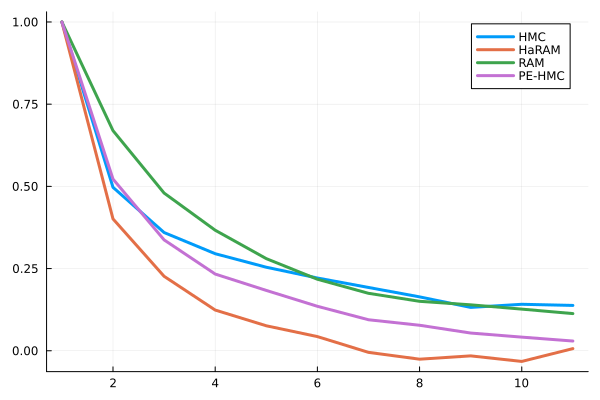

In [26]:
plt10_acf = acfplots(chains10d, names, lw=3)

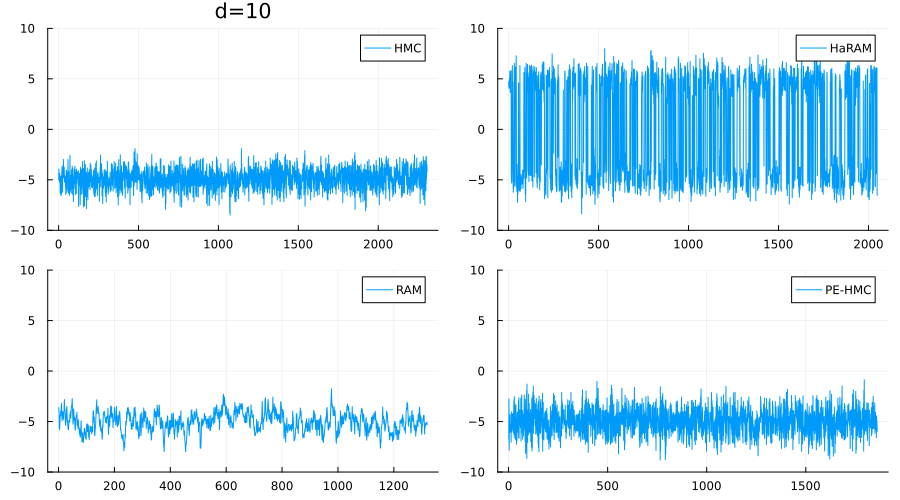

In [27]:
plt10_tr = traceplots(xs10d, names, lw=1, layout=(2,2), ylim=(-10,10), l=100, size=(900, 500), title=["d=$(model.d)" "" "" ""])

In [28]:
# @pipe ["plt10_tr", "plt10_acf", "plt10_hmc", "plt10_haram", "plt10_ram", "plt10_pehmc", "plt10_pt_hmc", "plt10_pt_haram"] .|> 
# begin
#     plot(eval(Meta.parse(_))); savefig.(plotsdir.("gaussian3/d10/" .* _ .* [".pdf", ".svg"] )) 
# end;

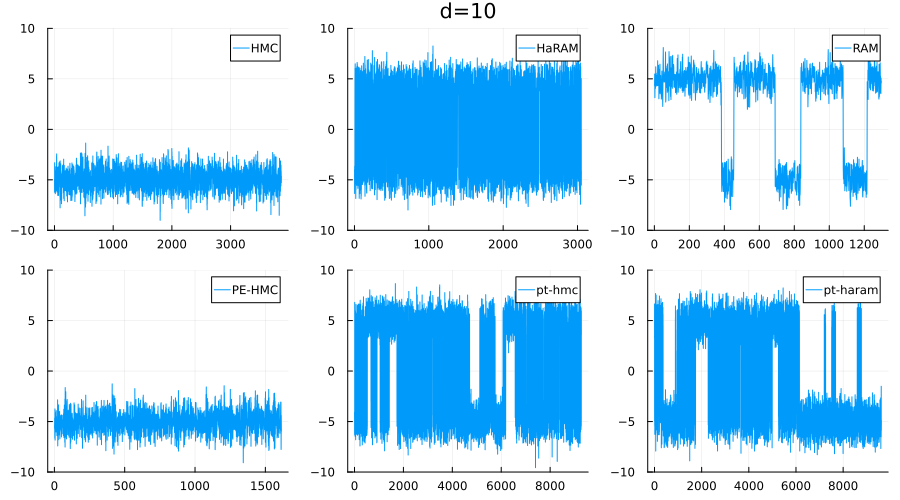

In [29]:
names = ("HMC", "HaRAM", "RAM", "PE-HMC")
names = ("HMC", "HaRAM", "RAM", "PE-HMC", "pt-hmc", "pt-haram")
xs10d = [x_10_hmc, x_10_haram, x_10_ram, x_10_pehmc, x_10_pt_hmc, x_10_pt_haram]
chains10d = [chain_10_hmc, chain_10_haram, chain_10_ram, chain_10_pehmc, chain_10_pt_hmc, chain_10_pt_haram];

plt10_acf_all = acfplots(chains2d, names, lw=3, title="d=10")
plt10_tr_all = traceplots(xs2d, names, lw=1, layout=(2,3), ylim=(-10,10), l=100, size=(900, 500), title=["" "d=10" "" "" "" "" ""])

# @pipe ["plt10_tr_all", "plt10_acf_all"] .|>
# begin 
#     plot(eval(Meta.parse(_))); savefig.(plotsdir.("gaussian3/d10/" .* _ .* [".pdf", ".svg"] )) 
# end;

In [30]:
w2_minibatch(xs10d, model)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


6-element Vector{Float64}:
 1.4707126359337945
 0.24888198828334004
 2.5202838129809155
 1.5182195626757795
 1.0496669176665097
 0.2740873068585904

In [39]:
d2 = [
    "plt2_tr", "plt2_acf", "plt2_tr_all", "plt2_acf_all", 
    "plt2_hmc", "plt2_haram", "plt2_ram", "plt2_pehmc", 
    "plt2_pt_hmc", "plt2_pt_haram"
] 
d10= [
    "plt10_tr", "plt10_acf", "plt10_tr_all", "plt10_acf_all",
    "plt10_hmc", "plt10_haram", "plt10_ram", "plt10_pehmc",
    "plt10_pt_hmc", "plt10_pt_haram"
]

using Pipe
@pipe [d2; d10].|> 
begin 
    plot(eval(Meta.parse(_))); savefig.(plotsdir.("gaussian3/d/" .* _ .* [".pdf", ".svg"] )) 
end;

"/storage/work/s/suv87/julia/haram/plots/gaussian3/d/plt.svg"

In [43]:
plot(
    (@pipe ["plt2_hmc", "plt2_haram", "plt2_ram", "plt2_pehmc"] .|> plot(eval(Meta.parse(_)), colorbar=false))...,
    layout=(2,2), size=(700, 500)
)
savefig.(plotsdir.("gaussian3/d/" .* "scatter2" .* [".pdf", ".svg"] ))

2-element Vector{String}:
 "/storage/work/s/suv87/julia/haram/plots/gaussian3/d/scatter2.pdf"
 "/storage/work/s/suv87/julia/haram/plots/gaussian3/d/scatter2.svg"

In [44]:
plot(
    (@pipe ["plt10_hmc", "plt10_haram", "plt10_ram", "plt10_pehmc"] .|> plot(eval(Meta.parse(_)), colorbar=false))...,
    layout=(2,2), size=(700, 500)
)
savefig.(plotsdir.("gaussian3/d/" .* "scatter10" .* [".pdf", ".svg"] ))

2-element Vector{String}:
 "/storage/work/s/suv87/julia/haram/plots/gaussian3/d/scatter10.pdf"
 "/storage/work/s/suv87/julia/haram/plots/gaussian3/d/scatter10.svg"